# Using MLRUN with MpiJobs (Horovod)

In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config spec.build.baseImage = "python:3.6-jessie"

%nuclio: setting spec.build.baseImage to 'python:3.6-jessie'


## Helper functions for downloading and labeling images

In [3]:
import os
import zipfile
import json
from tempfile import mktemp
import pandas as pd


def open_archive(context, 
                 target_dir='content',
                 archive_url=''):
    """Open a file/object archive into a target directory"""
        
    # Define locations
    os.makedirs(target_dir, exist_ok=True)
    context.logger.info('Verified directories')
    
    # Extract dataset from zip
    context.logger.info('Extracting zip')
    zip_ref = zipfile.ZipFile(archive_url, 'r')
    zip_ref.extractall(target_dir)
    zip_ref.close()
    
    context.logger.info(f'extracted archive to {target_dir}')
    context.log_artifact('content', target_path=target_dir)

    
from mlrun.artifacts import TableArtifact

def categories_map_builder(context,
                           source_dir,
                           df_filename='file_categories_df.csv',
                           map_filename='categories_map.json'):
    """Read labeled images from a directory and create category map + df
    
    filename format: <category>.NN.jpg"""
    
    # create filenames list (jpg only)
    filenames = [file for file in os.listdir(source_dir) if file.endswith('.jpg')]
    categories = []
        
    # Create a pandas DataFrame for the full sample
    for filename in filenames:
        category = filename.split('.')[0]
        categories.append(category)

    df = pd.DataFrame({
        'filename': filenames,
        'category': categories
    })
    df['category'] = df['category'].astype('str')
    
    categories = df.category.unique()
    categories = {i: category for i, category in enumerate(categories)}
    with open(os.path.join(context.out_path, map_filename), 'w') as f:
        f.write(json.dumps(categories))
        
    context.logger.info(categories)
    context.log_artifact('categories_map', src_path=map_filename)
    context.log_artifact(TableArtifact('file_categories', df=df, src_path=df_filename))

In [4]:
# nuclio: end-code

# Complete Data-Science Pipeline with MLRun

- Get data
- Create categories map
- Train horovod model on the cluster
- Deploy model

In [5]:
from mlrun import new_function, code_to_function, get_run_db, mount_v3io, NewTask, mlconf, new_model_server
# for local DB path use 'User/mlrun' instead 
mlconf.dbpath = 'http://mlrun-db:8080'

In [6]:
base_dir = '/User/mlrun/examples'
images_path = os.path.join(base_dir, 'images')

### Step 1: Download and extract image archive

In [7]:
# download images from s3 using the local `open_archive` function
open_archive_task = NewTask('download', handler=open_archive, 
               params={'target_dir': images_path},
               inputs={'archive_url': 'http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip'})
open_archive_fn = new_function().run(open_archive_task)

[mlrun] 2019-11-11 13:40:21,747 starting run download uid=1d9a2a036f8f4430b61f18ec152d5a92  -> http://mlrun-db:8080
[mlrun] 2019-11-11 13:40:21,979 downloading http://iguazio-sample-data.s3.amazonaws.com/catsndogs.zip to local tmp
[mlrun] 2019-11-11 13:40:23,575 Verified directories
[mlrun] 2019-11-11 13:40:23,576 Extracting zip
[mlrun] 2019-11-11 13:40:43,026 extracted archive to /User/mlrun/examples/images


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...2d5a92,0,Nov 11 13:40:21,completed,download,v3io_user=adminkind=handlerowner=iguaziorepo=https://github.com/mlrun/demos.gitcommit=b23cedd3f7cda809b3ff4fafff6f64764f175638host=jupyter-dulwoc9x63-ixir3-68dccc6b7-4psd5,archive_url,target_dir=/User/mlrun/examples/images,,content


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 1d9a2a036f8f4430b61f18ec152d5a92 
[mlrun] 2019-11-11 13:40:43,093 run executed, status=completed


### Step 2: Tag Images with Categories (cat & dog)

In [8]:
# Create categories map
label_task = NewTask('label', handler=categories_map_builder, out_path=images_path,
                              params={'source_dir': os.path.join(images_path, 'cats_n_dogs')})
labeler_function = new_function().run(label_task)

[mlrun] 2019-11-11 13:41:26,853 starting run label uid=028762ec8e15465991ce12b6e2f1afac  -> http://mlrun-db:8080
[mlrun] 2019-11-11 13:41:27,043 {0: 'cat', 1: 'dog'}


uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...f1afac,0,Nov 11 13:41:26,completed,label,v3io_user=adminkind=handlerowner=iguaziorepo=https://github.com/mlrun/demos.gitcommit=b23cedd3f7cda809b3ff4fafff6f64764f175638host=jupyter-dulwoc9x63-ixir3-68dccc6b7-4psd5,,source_dir=/User/mlrun/examples/images/cats_n_dogs,,categories_mapfile_categories


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid 028762ec8e15465991ce12b6e2f1afac 
[mlrun] 2019-11-11 13:41:27,152 run executed, status=completed


### Step 3: Distributed Training with TensorFlow, Keras and Horovod

In [9]:
code_dir = '/User/mlrun'
HOROVOD_FILE = os.path.join(code_dir, 'horovod-training.py')

params = {
    'checkpoints_dir' : os.path.join(base_dir, 'checkpoints'),
    'model_path' : os.path.join(base_dir, 'models/cats_n_dogs.h5'),
    'epochs' : 1,
    'batch_size' : 64,
    'image_width': 128,
    'image_height': 128,
    'image_channels': 3
}

inputs = {
    'data_path' : os.path.join(images_path, 'cats_n_dogs'),    
    'categories_map': labeler_function.outputs['categories_map'],
    'file_categories': labeler_function.outputs['file_categories']
}

image = 'mlrun/mpijob:dev'
trainer = new_function(name='horovod-trainer',
                       command='mpijob://{}'.format(HOROVOD_FILE), 
                       image=image,
                       interactive=True)
trainer.apply(mount_v3io())
trainer.spec.image_pull_policy = 'Always'
trainer.spec.replicas = 4
# trainer.gpus(1)
mprun = trainer.run(name='train', params=params, out_path='/User/mlrun', inputs=inputs)

[mlrun] 2019-11-11 13:41:41,141 starting run train uid=c2f034cae48b4f0c82385c1b8a75cdca  -> http://mlrun-db:8080
[mlrun] 2019-11-11 13:41:41,312 using in-cluster config.
[mlrun] 2019-11-11 13:41:41,326 MpiJob train-4e87da8c created
[mlrun] 2019-11-11 13:41:49,356 MpiJob train-4e87da8c state=Active
..
+ POD_NAME=train-4e87da8c-worker-1
+ shift
+ /opt/kube/kubectl exec train-4e87da8c-worker-1 -- /bin/sh -c     PATH=/usr/local/bin:$PATH ; export PATH ; LD_LIBRARY_PATH=/usr/local/lib:$LD_LIBRARY_PATH ; export LD_LIBRARY_PATH ; DYLD_LIBRARY_PATH=/usr/local/lib:$DYLD_LIBRARY_PATH ; export DYLD_LIBRARY_PATH ;   /usr/local/bin/orted -mca ess "env" -mca ess_base_jobid "3269525504" -mca ess_base_vpid 2 -mca ess_base_num_procs "5" -mca orte_node_regex "train-[1:4]e87da8c-launcher-j2mz8,train-[1:4]e87da8c-worker-0,train-[1:4]e87da8c-worker-1,train-[1:4]e87da8c-worker-2,train-[1:4]e87da8c-worker-3@0(5)" -mca orte_hnp_uri "3269525504.0;tcp://10.233.81.167:53153" -mca plm "rsh" --tree-spawn -mca orte

uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
...75cdca,0,Nov 11 13:41:56,completed,train,commit=b23cedd3f7cda809b3ff4fafff6f64764f175638host=train-4e87da8c-worker-0kind=mpijobmlrun/job=train-4e87da8cowner=iguaziorepo=https://github.com/mlrun/demos.gitv3io_user=admin,categories_mapdata_pathfile_categories,batch_size=64checkpoints_dir=/User/mlrun/examples/checkpointsepochs=1image_channels=3image_height=128image_width=128model_path=/User/mlrun/examples/models/cats_n_dogs.h5,accuracy=0.5821875333786011loss=0.812899595797062,modelsummary.html


type result.show() to see detailed results/progress or use CLI:
!mlrun get run --uid c2f034cae48b4f0c82385c1b8a75cdca 
[mlrun] 2019-11-11 13:50:01,163 run executed, status=completed


In [13]:
fn.delete_job('train-1bd63853')

[mlrun] 2019-10-28 21:36:55,558 del status: Success


### Step 4: Deploy Model Serving Function
The following code will use a Nuclio serving function a Notebook format and will deploy it with proper arguments 

In [10]:
model_name = 'cat_dog_v1'

In [11]:
# convert the notebook code to deployable function, configure it
from mlrun import code_to_function
inference_function = code_to_function(name='tf-image-serving', 
                                      filename='./nuclio-serving-tf-images.ipynb',
                                      runtime='nuclio')

# set the API/trigger, attach the home dir to the function
inference_function.with_http(workers=2).add_volume('User','~/')

# set the model file path SERVING_MODEL_<name> = <model file path>
inference_function.set_env(f'SERVING_MODEL_{model_name}', params['model_path'])
inference_function.set_env('classes_map', inputs['categories_map'])
addr = inference_function.deploy(project='nuclio-serving')

[mlrun] 2019-11-11 13:50:17,439 deploy started
[nuclio.deploy] 2019-11-11 13:50:18,531 (info) Building processor image
[nuclio.deploy] 2019-11-11 13:50:23,580 (info) Build complete
[nuclio.deploy] 2019-11-11 13:50:27,623 (info) Function deploy complete
[nuclio.deploy] 2019-11-11 13:50:27,631 done updating tf-image-serving, function address: 13.58.34.174:32204


### Test The Serving Function (with Image URL)

In [15]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

{"prediction": ["cat"], "dog-probability": [5.002967977815161e-22]}


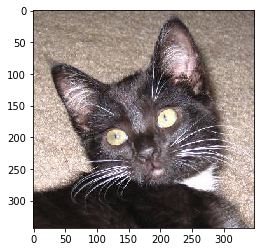

In [14]:
cat_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/cat.102.jpg'
response = requests.get(cat_image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

headers = {'Content-type': 'text/plain'}
response = requests.post(url=addr + f'/predict/{model_name}', data=cat_image_url, headers=headers)
print(response.content.decode('utf-8'))

### Test The Serving Function (with Jpeg Image)

{"prediction": ["dog"], "dog-probability": [1.0]}


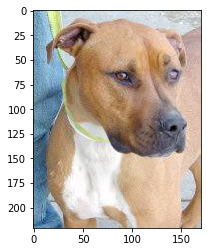

In [17]:
cat_image_url = 'https://s3.amazonaws.com/iguazio-sample-data/images/catanddog/dog.105.jpg'
response = requests.get(cat_image_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

headers = {'Content-type': 'image/jpeg'}
response = requests.post(url=addr + f'/predict/{model_name}', data=response.content, headers=headers)
print(response.content.decode('utf-8'))

### Alternative: Deploy Function From Pre-built (container) Image

In [ ]:
# Declare model server
srvfn = new_model_server('tf-image-server', 
                         models={model_name: params['model_path']}, 
                         model_class='TFModel',
                         image='zilbermanor/nuclio-serving-tf-image-server:latest')
srvfn.with_v3io('User','~/')  # Add v3io mount
srvfn.spec.env['IMAGE_WIDTH'] = 128
srvfn.spec.env['IMAGE_HEIGHT'] = 128
srvfn.spec.env['classes_map'] = '/User/mlrun/examples/categories_map.json'

# Deploy
addr = srvfn.deploy(project='nuclio-serving')